# AI model for predicting the electricity prices

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the data

In [ ]:
# path to numpy files
arima = 'output/forecast_ARIMA.npy'
lstm = 'output/forecast_LSTM.npy'
sarimax = 'output/forecast_sarimax.npy'
data = '../../data/fulldata.csv'

# load numpy files
arima_forecast = np.load(arima)
sarimax_forecast = np.load(sarimax)
lstm_forecast = np.load(lstm)

# load test data
data = pd.read_csv(data)
data = data[['SpotPriceDKK', 'from']]
data['from'] = pd.to_datetime(data['from'])
data = data.set_index('from')
data = data[data.index >= '2024-08-01']
data.sort_index(inplace=True)
# ensure lengths match
actuals = data['SpotPriceDKK'].values


# length of test data
print(len(arima_forecast), len(lstm_forecast), len(sarimax_forecast), len(data))

2880 2880 2904 2904


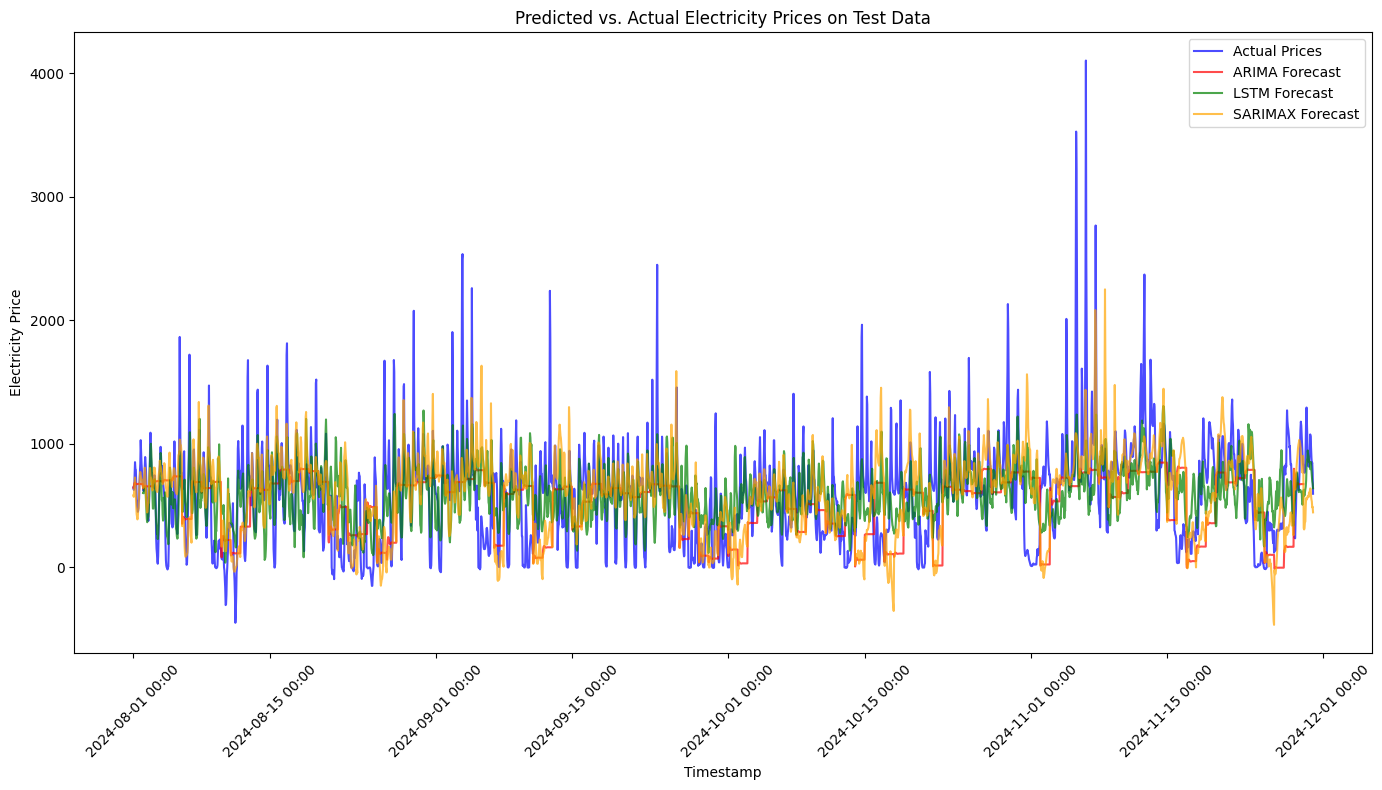

In [ ]:
# extract 'from' timestamps from test_data, adjusted for seq_length
# since the dataset uses sequences, the first 'seq_length' targets are not included in 'actuals' and 'predictions'
timestamps = data.index.values

# create the plot
plt.figure(figsize=(14, 8))
plt.plot(timestamps, actuals, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(timestamps[:len(arima_forecast)], arima_forecast, label='ARIMA Forecast', color='red', alpha=0.7)
plt.plot(timestamps[24:], lstm_forecast, label='LSTM Forecast', color='green', alpha=0.7)
plt.plot(timestamps[:len(sarimax_forecast)], sarimax_forecast, label='SARIMAX Forecast', color='orange', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices on Test Data')

# format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/predicted_v_actuals.png')

plt.show()

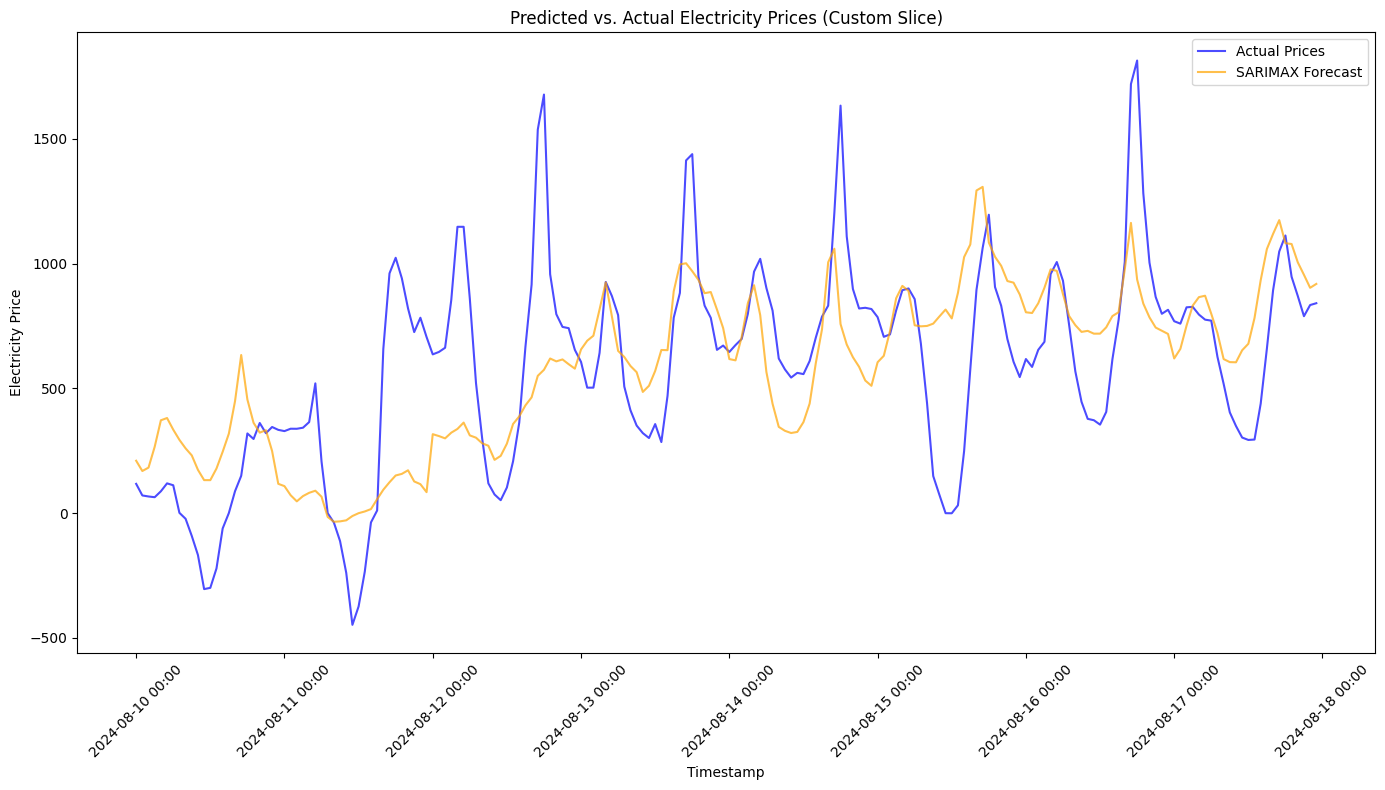

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define the range of points (indices) you want to plot
FROM_IDX = 24*9     # inclusive start
TO_IDX   = 24*17   # exclusive end

# Extract timestamps from the dataset
timestamps = data.index.values

# Slice everything according to [FROM_IDX : TO_IDX]
actuals_slice        = actuals[FROM_IDX:TO_IDX]
arima_forecast_slice = arima_forecast[FROM_IDX:TO_IDX]
sarimax_slice        = sarimax_forecast[FROM_IDX:TO_IDX]

# For the LSTM forecast that starts at an offset (24 steps in this example),
# the code below assumes LSTM predictions start at index 24 relative to the original dataset.
# So if we want the same “view window” on the graph:
# - We'll slice the LSTM predictions from [FROM_IDX : TO_IDX - 24], 
# - We'll also slice the timestamps accordingly from [FROM_IDX + 24 : TO_IDX].
lstm_forecast_slice  = lstm_forecast[FROM_IDX : TO_IDX - 24]     # offset LSTM
timestamps_slice_all = timestamps[FROM_IDX:TO_IDX]
timestamps_slice_lstm = timestamps[FROM_IDX + 24 : TO_IDX]       # alignment

# Create the plot
plt.figure(figsize=(14, 8))
plt.plot(timestamps_slice_all, actuals_slice,        label='Actual Prices',    color='blue',   alpha=0.7)
# plt.plot(timestamps_slice_all, arima_forecast_slice, label='ARIMA Forecast',   color='red',    alpha=0.7)
plt.plot(timestamps_slice_all, sarimax_slice,        label='SARIMAX Forecast', color='orange', alpha=0.7)
# plt.plot(timestamps_slice_lstm, lstm_forecast_slice, label='LSTM Forecast',    color='green',  alpha=0.7)

plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices (Custom Slice)')

# Format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/predicted_v_actuals_subset.png')
plt.show()


In [40]:
print(f'ARIMA RMSE:{root_mean_squared_error(actuals[:len(arima_forecast)], arima_forecast)}\nARIMA MAE:{mean_absolute_error(actuals[:len(arima_forecast)], arima_forecast)}\n')
print(f'LSTM RMSE:{root_mean_squared_error(actuals[:len(lstm_forecast)], lstm_forecast)}\nLSTM MAE:{mean_absolute_error(actuals[:len(lstm_forecast)], lstm_forecast)}\n')
print(f'SARIMAX RMSE:{root_mean_squared_error(actuals[:len(sarimax_forecast)], sarimax_forecast)}\nSARIMAX MAE:{mean_absolute_error(actuals[:len(sarimax_forecast)], sarimax_forecast)}\n')

ARIMA RMSE:418.10233783428515
ARIMA MAE:309.3335528234743

LSTM RMSE:287.24784152135055
LSTM MAE:213.28160293198846

SARIMAX RMSE:404.4313092617584
SARIMAX MAE:302.12707759875383

